In [72]:
from pathlib import Path
import torch
import json
import numpy as np
from scipy.spatial import distance
from models.DAE import Decoder
import pandas as pd
import networkx as nx
from utils import to_img, get_device
import matplotlib.pyplot as plt
from graph import get_graph, get_most_distant_points, get_sorted_nn_graph
from mpl_toolkits.mplot3d import Axes3D


In [73]:
BASE_PATH = Path(r'benchmarks/model2') 

MODEL_PATH= BASE_PATH / Path('model.pth')
ENCODING_PATH= BASE_PATH / Path('encoding.json')
CONFIG_PATH= BASE_PATH / Path('config.json')

In [74]:
with ENCODING_PATH.open() as f:
    points_data = json.load(f)
    
points=[p['z'] for p in points_data]
dims = len(points[0])
pd.DataFrame(points).head()
pd.DataFrame(points).shape[0]


1600

In [75]:
with CONFIG_PATH.open() as f:
    config = json.load(f)
print(config)
dims= config['dims']

device = get_device()
state_dict = torch.load(MODEL_PATH, map_location=torch.device(device))
decoder = Decoder(dims)
decoder.load_state_dict(state_dict['decoder'])
decoder.to(device)

{'lr': 0.01, 'wd': 1e-05, 'num_epochs': 600, 'batch_size': 8, 'step_size': 100, 'dims': 2}


Decoder(
  (fc1): Linear(in_features=2, out_features=4096, bias=True)
  (deconv1): ConvTranspose2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
  (relu1): ReLU()
  (deconv2): ConvTranspose2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
  (relu2): ReLU()
  (deconv3): ConvTranspose2d(64, 3, kernel_size=(2, 2), stride=(1, 1), padding=(2, 2))
  (tanh): Tanh()
)

In [76]:
G = get_graph(points,dist_type='euclidean',start_k=1, max_k=1000)
k = max(deg for deg in G.degree)[1]
print('minimal degree for graph to be connected is {}'.format(k))

minimal degree for graph to be connected is 4


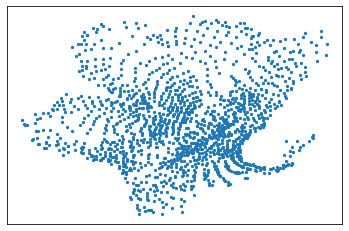

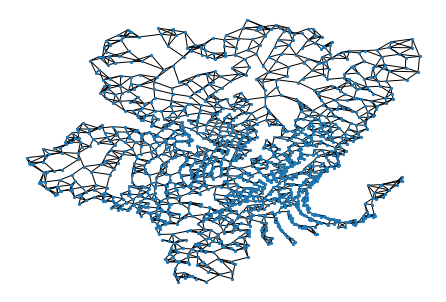

In [77]:
if len(points[0])==2:

    pos= nx.get_node_attributes(G,'pos')
    nx.draw_networkx_nodes(G, pos, node_size=5)
    plt.show()
    nx.draw(G, pos, node_size=5)
    plt.show()

if len(points[0])==3:
    %matplotlib inline 
    # so we can rotate stuff around
    import random
    pos = nx.get_node_attributes(G, 'pos')

    angle = 0
    with plt.style.context(('ggplot')):

        fig = plt.figure(figsize=(10,7))
        ax = Axes3D(fig)

        # Loop on the pos dictionary to extract the x,y,z coordinates of each node

        for key, value in pos.items():
            xi = value[0]
            yi = value[1]
            zi = value[2]
            #rint('here')
            ax.scatter(xi, yi, zi, s=1, c='blue')

        # Loop on the list of edges to get the x,y,z, coordinates of the connected nodes
        # Those two points are the extrema of the line to be plotted
        #edges = random.sample(list(G.edges()), 500) # sample as this is too much
#         for i,j in enumerate(nx.bfs_edges(G, 0)):
#             x = np.array((pos[j[0]][0], pos[j[1]][0]))
#             y = np.array((pos[j[0]][1], pos[j[1]][1]))
#             z = np.array((pos[j[0]][2], pos[j[1]][2]))
#             ax.plot(x, y, z, c='blue', alpha=0.5)
            

    # Set the initial view

    ax.view_init(0, 0)
    # Hide the axes
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    #x.set_axis_off()
    print('just show')
    plt.show()

In [78]:

if len(points[0])==3:
    from scipy.spatial import ConvexHull
    pts = np.array(points)

    hull = ConvexHull(pts)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")

    # Plot defining corner points
    #ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")

    # 12 = 2 * 6 faces are the simplices (2 simplices per square face)
    for s in hull.simplices:
        s = np.append(s, s[0])  # Here we cycle back to the first coordinate
        ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "r-")

    # Make axis label
    for i in ["x", "y", "z"]:
        eval("ax.set_{:s}label('{:s}')".format(i, i))

    plt.show()



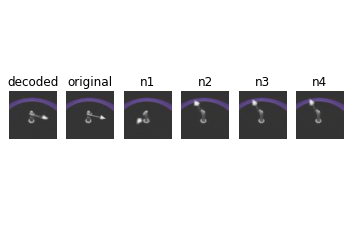

In [79]:
import PIL.Image as Image


def latent_to_img(vector):
    reshaped = torch.from_numpy(np.expand_dims(np.array(vector), axis=0)).type(torch.FloatTensor).to(device)
    original = decoder(reshaped)
    img = to_img(original)[0].permute(1,2,0).detach().numpy()
    return img

idx=0
original = latent_to_img(points[idx])
fig = plt.figure()
plt.axis('off')

num_axes = min(k, 5)
ax1 = fig.add_subplot(1,num_axes+2,1)
ax1.axis('off')
ax1.set_title('decoded')
ax1.imshow(original)


ax2 = fig.add_subplot(1,num_axes+2, 2)
ax2.axis('off')
ax2.imshow(Image.open(points_data[idx]['path']))
ax2.set_title('original')

for i,neighbors in enumerate(list(G.neighbors(idx))[:num_axes], start=3):
    ax = fig.add_subplot(1,num_axes+2,i)
    ax.set_title('n'+ str(i-2))
    img = latent_to_img(points[i])
    ax.axis('off')
    ax.imshow(img)
plt.show()



In [80]:
#get most distant points
I = get_most_distant_points(points, dist_type='euclidean')

print("most distant points are at indexes {}".format(I))

most distant points are at indexes (182, 220)


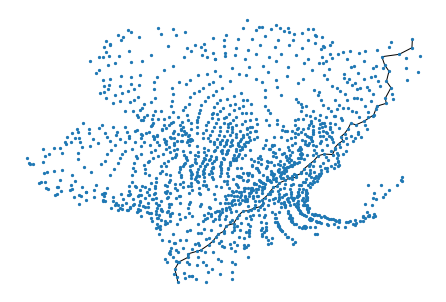

In [81]:
path = nx.dijkstra_path(G, I[0], I[1], weight='weight')
G2= nx.Graph()
G2.add_nodes_from(G.nodes(data=True))
for i in range(len(path)-1):
    data = G.get_edge_data(path[i], path[i+1])
    G2.add_edge(path[i], path[i+1], weight=data['weight'])
    
pos= nx.get_node_attributes(G2,'pos')

if len(points[0])==2:
    nx.draw(G2, pos, node_size=5)
    plt.show()

if len(points[0])==3:
    with plt.style.context(('ggplot')):

        fig = plt.figure(figsize=(10,7))
        ax = Axes3D(fig)

        # Loop on the pos dictionary to extract the x,y,z coordinates of each node

        for key, value in pos.items():
            xi = value[0]
            yi = value[1]
            zi = value[2]
            #rint('here')
            ax.scatter(xi, yi, zi, s=1, c='blue')

        # Loop on the list of edges to get the x,y,z, coordinates of the connected nodes
        # Those two points are the extrema of the line to be plotted
        for i,j in enumerate(G2.edges()):
            x = np.array((pos[j[0]][0], pos[j[1]][0]))
            y = np.array((pos[j[0]][1], pos[j[1]][1]))
            z = np.array((pos[j[0]][2], pos[j[1]][2]))
            ax.plot(x, y, z, c='black', alpha=0.5)

    # Set the initial view

    ax.view_init(30, 40)
    # Hide the axes
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    #x.set_axis_off()
    print('just show')
    plt.show()



In [82]:
n_images=len(path)*2+1 #assuming number of images is k*len(path) + 1

def generate_extra_points(u, v, n_points):
    u = np.array(u)
    v = np.array(v)
    
    alphas = np.linspace(0, 1, n_points)[1:-1]
    points = []
    for alpha in alphas:
        points.append(alpha *u + (1-alpha)*v)
    return points
    
interpolation_path = []
for i in range(len(path)-1):
    images_to_generate = n_images // len(path) - 1
    u = points[path[i]]
    v = points[path[i+1]]
    new_points = generate_extra_points(u,v, images_to_generate)
    interpolation_path.extend([u]+new_points+[v])
print(len(interpolation_path))

    


126


<Figure size 432x288 with 0 Axes>

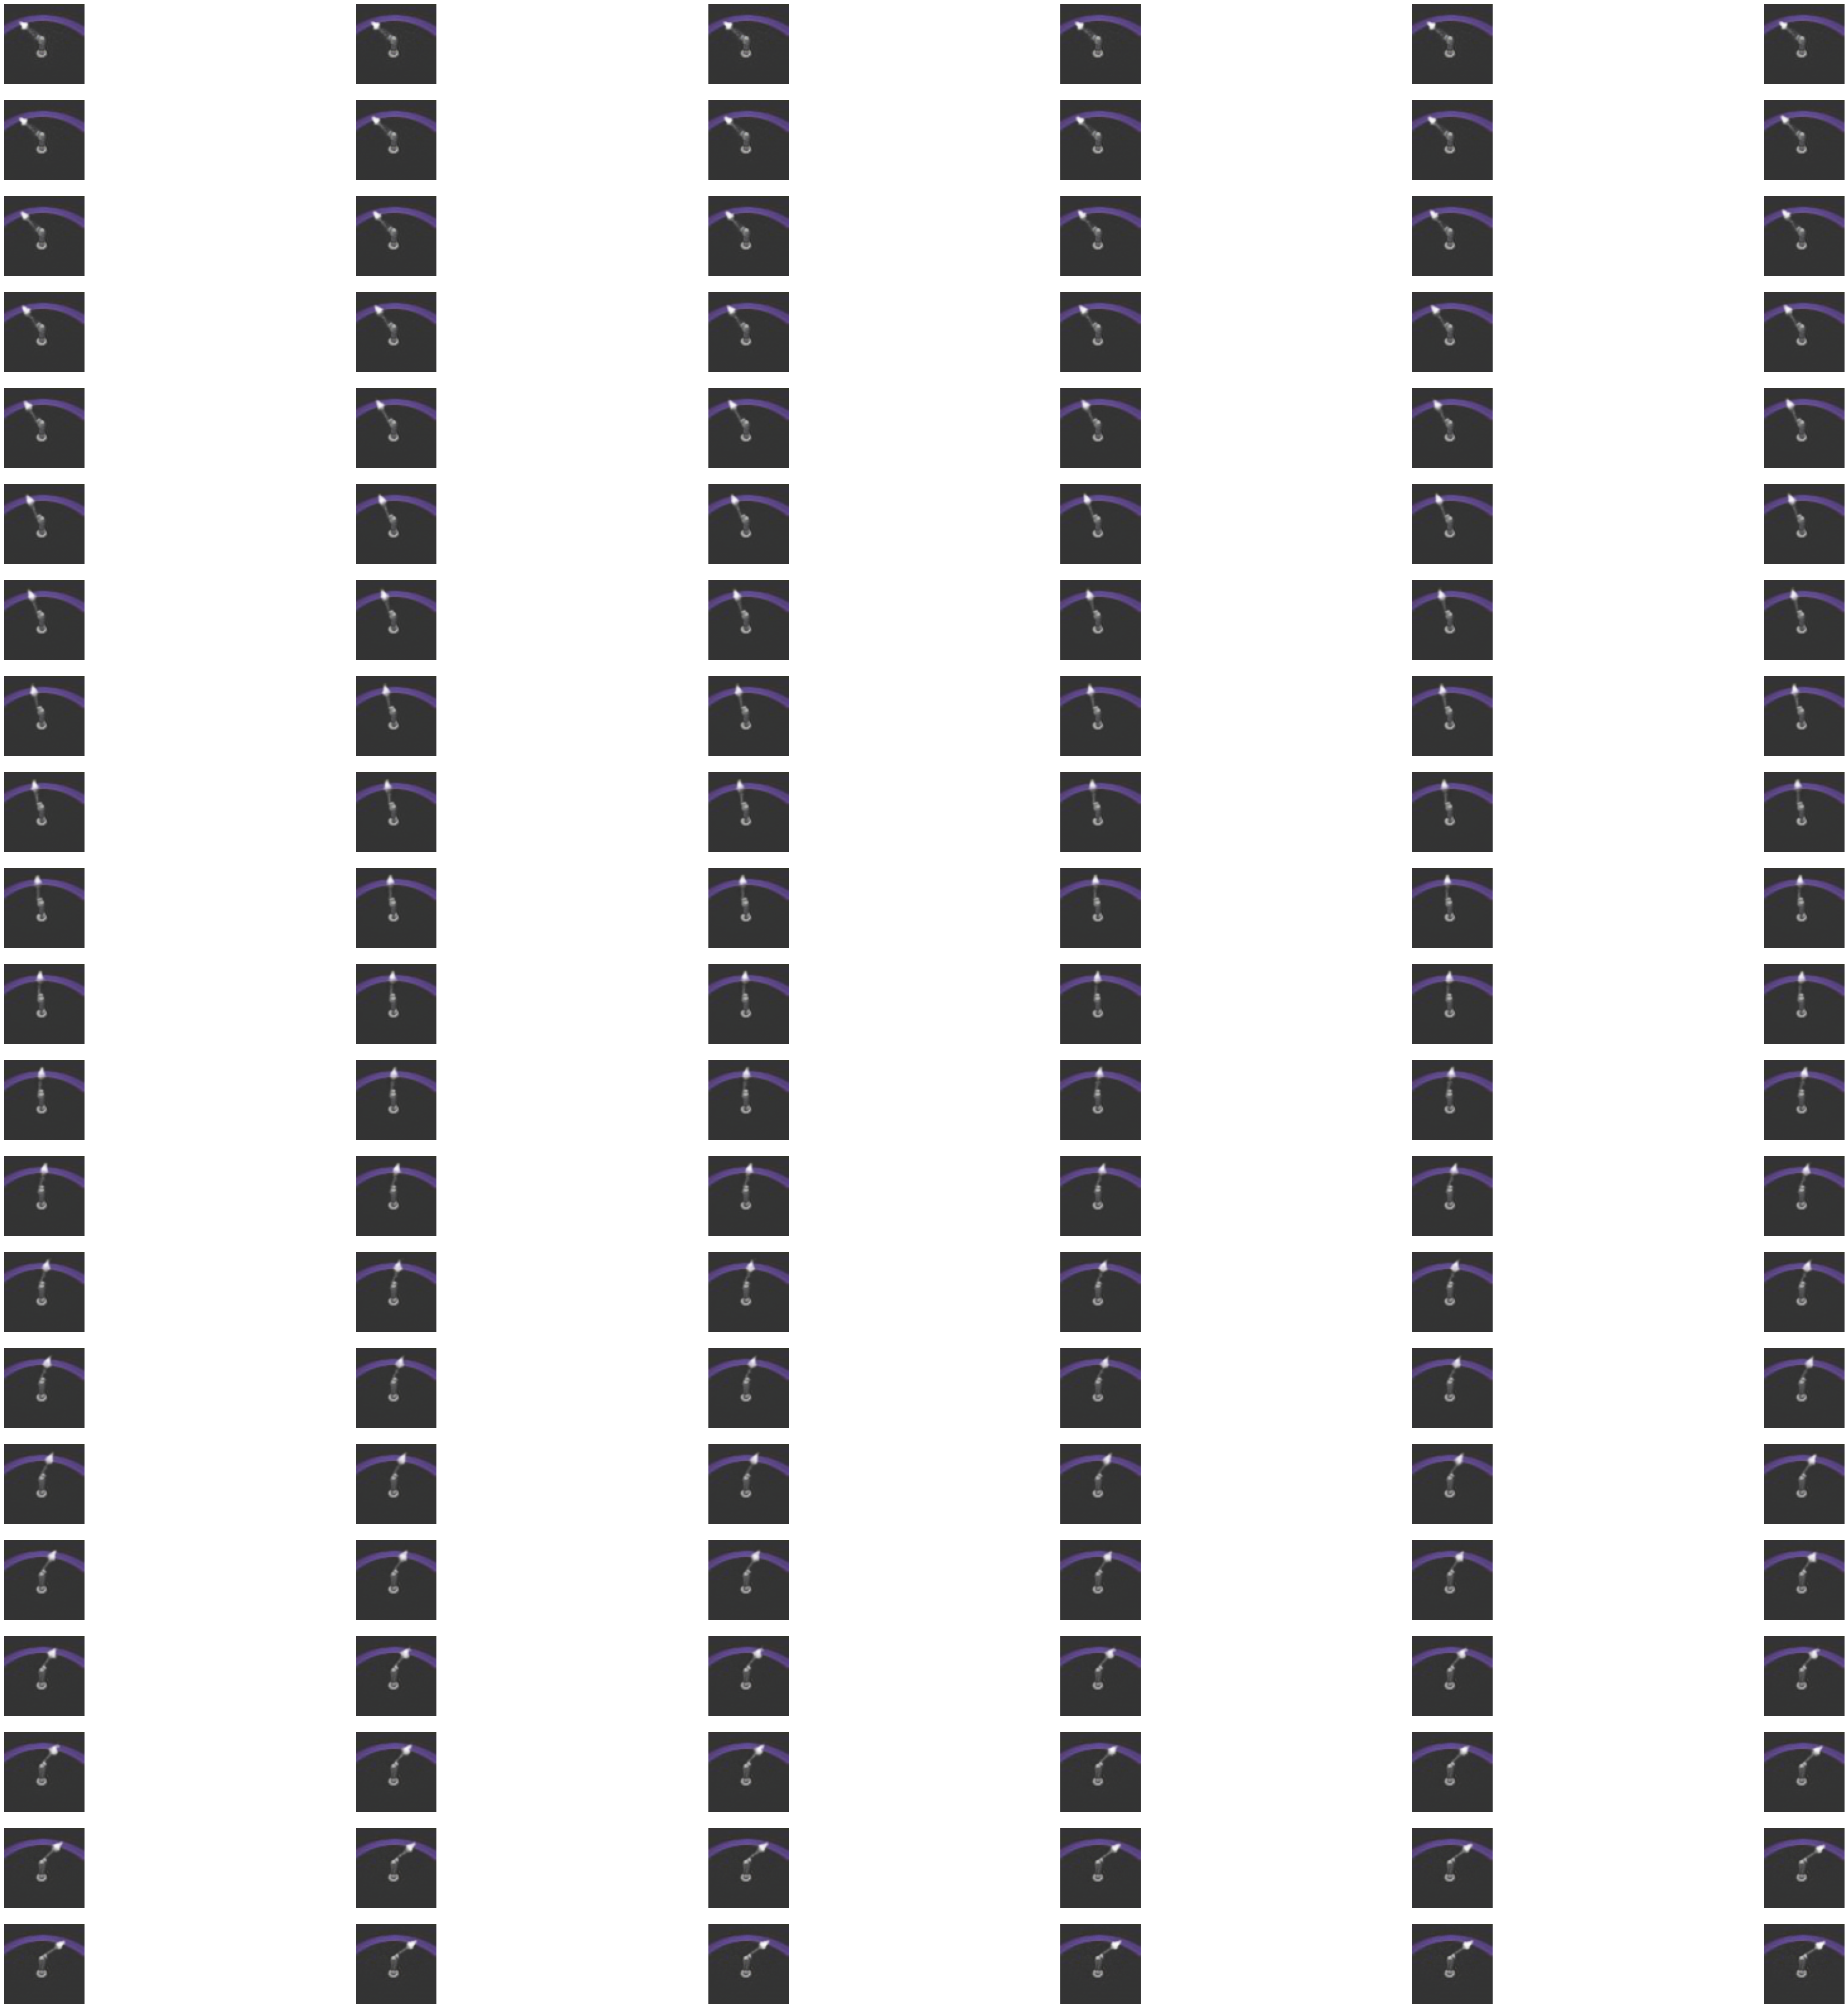

In [83]:
fig = plt.figure()

w=10
h=10
fig=plt.figure(figsize=(64, 64))
columns = 6
rows = np.ceil(len(interpolation_path)/columns)
for i in range(1, len(interpolation_path) +1):
    img = latent_to_img(interpolation_path[i-1])
    ax = fig.add_subplot(rows, columns, i)
    ax.axis('off')
    ax.imshow(img)
plt.show()
    